# What is survival analysis, and when do you need it?

Program for this talk:

1. What is right-censored time-to-event data and why naive regression models fail
   on such data?
2. Use-cases and limitations
3. Modeling
   - Unconditional survival analysis with Kaplan Meier
   - Conditional survival analysis with Cox Proportional Hazards, a log-linear estimator
   - Conditional survival analysis and competing risk with SurvivalBoost, a non linear
     boosting tree method.

---


## 1. What is right-censored time-to-event data?

### Censoring

Survival analysis is a time-to-event regression problem, with censored data. We call censored all individuals that didn't experience the event during the range of the observation window.

In our setting, we're mostly interested in right-censored data, meaning we that the event of interest did not occur before the end of the observation period (typically the time of collection of the dataset):

<figure>
<img src="censoring.png" style="width:80%">
<figcaption align = "center"> <i>image credit: scikit-survival</i> </figcaption>
</figure>

Individuals can join the study at the same or different times, and the study may or may not be ended by the time of observation.

Survival analysis techniques have wide applications:

- In the **medical** landscape, events can consist in patients dying of cancer, or on the contrary recovering from some disease.
- In **predictive maintenance**, events can consist in machine failure.
- In **insurance**, we are interesting in modeling the time to next claim for a portfolio of insurance contracts.
- In **marketing**, we can consider user churning as events, or we could focus on users becoming premium (members that choose to pay a subscription after having used the free version of service for a while).

Answering questions like:
- What is the probability that a new user churn in 6 months? 9 months?
- How long does it take for this churn probability to be 50%?

As we will see, for all those applications, it is not possible to directly train a machine learning-based regression model on such a **right-censored** time-to-event target since we only have a lower bound on the true time to event for some data points. **Naively removing such points from the dataset would cause the model predictions to be biased**.


## Our Tasks

Some notations:

We denote the observed time-to-event $T = \min(T^*, C)$, where: 
- $T^* \in \mathbb{R}_+$ is the event time
- $C \in \mathbb{R}_+$ is the censoring time

We observe $(\bold{X},T,\Delta) \sim D$, where:
- $\bold{X} \sim \mathcal{X}$ are our covariates
- $\Delta \in [0,1]$ is the event indicator, 0 is a censored observation.

However, we are primarily interested in the distribution $(\bold{X}, T^*, \Delta) \sim \mathcal{D}^*$, particularly the joint distribution $T^*, \Delta|\bold{X}$.

Our main quantities of interest to estimate are:
- The Survival Function: $S^*(t|\bold{x})=P(T^*>t|\bold{X=x})$. This represents the probability that an event doesn't occur at or before some given time $t$
- The Cumulative Incidence function: $F^*(t|\bold{x}) = 1 - S^*(t|\bold{x}) = P(T^* \leq t \cap \Delta=1|\bold{X=x})$

### Our target `y`

For each individual $i\in[1, N]$, our survival analysis target $y_i$ is comprised of two elements:

- The event indicator $\delta_i\in\{0, 1\}$, where $0$ marks censoring and $1$ is indicative that the event of interest has actually happened before the end of the observation window.
- The censored time-to-event $d_i=min(t_{i}, c_i) > 0$, that is the minimum between the date of the experienced event $t_i$ and the censoring date $c_i$. In a real-world setting, we don't have direct access to $t_i$ when $\delta_i=0$. We can only record $d_i$.

Here is how we represent our target:

In [1]:
from hazardous.data import make_synthetic_competing_weibull

X, y = make_synthetic_competing_weibull(
    n_events=1, n_samples=50, random_state=0, return_X_y=True
)
y.head()

,event,duration
0,1,14233.9
1,1,2029.2
2,0,21436.1
3,1,17154.8
4,1,642.3


### Why is it a problem to train time-to-event regression models?

Without survival analysis, we have two naive options to deal with right-censored time to event data:
- We ignore censorted data points from the dataset, only keep events that happened and perform naive regression on them.
- We consider that all censored events happen at the end of our observation window.

**Both approaches are wrong and lead to biased results.**

Let's compute the average and median time to event using either of those naive approaches on our truck failure dataset. We will compare them to the mean of the ground-truth event time $T$, that we would obtained with an infinite observation window. 

Note that we have access to the random variable $T$ because we generated this synthetic dataset. With real-world data, you only have access to $Y = \min(T, C)$, where $C$ is a random variable representing the censoring time.

In [2]:
event_mask = y["event"].astype(bool)
y.loc[event_mask]["duration"].median()

np.float64(3873.2)

In [3]:
y_max_impute = y.copy()
y_max_impute.loc[~event_mask, "duration"] = y_max_impute["duration"].max()
y_max_impute["duration"].median()

np.float64(6995.049999999999)

In [4]:
_, y_uncensored = make_synthetic_competing_weibull(
    n_events=1,
    n_samples=50,
    random_state=0,
    return_X_y=True,
    censoring_relative_scale=0,
)
y_uncensored["duration"].median()

np.float64(6422.4)

Let's start with unconditional estimation of the any event survival curve.

## Unconditional survival analysis with Kaplan-Meier

We now introduce the survival analysis approach to the problem of estimating the time-to-event from censored data. For now, we ignore any information from $X$ and focus on $y$ only.

Here our quantity of interest is the survival probability:

$$S(t)=P(T > t)$$ 

This represents the probability that an event doesn't occur at or before some given time $t$, i.e. that it happens at some time $T > t$.

The most commonly used method to estimate this function is the **Kaplan-Meier** estimator. It gives us an **unbiased estimate of the survival probability**. It can be computed as follows:

$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$

Where:

- $t_i$ is the time of event for individual $i$ that experienced the event,
- $d_i$ is the number of individuals having experienced the event at $t_i$,
- $n_i$ are the remaining individuals at risk at $t_i$.

Note that **individuals that were censored before $t_i$ are no longer considered at risk at $t_i$**.

Contrary to machine learning regressors, this estimator is **unconditional**: it only extracts information from $y$ only, and cannot model information about each individual typically provided in a feature matrix $X$.

In a real-world application, we aim at estimating $\mathbb{E}[T]$ or $Q_{50\%}[T]$. The latter quantity represents the median survival duration i.e. the duration before 50% of our population at risk experiment the event.

We can also be interested in estimating the survival probability after some reference time $P(T > t_{ref})$, e.g. a random clinical trial estimating the capacity of a drug to improve the survival probability after 6 months.

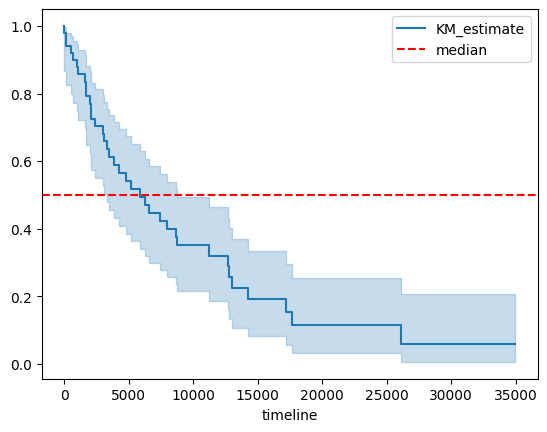

In [5]:
from lifelines import KaplanMeierFitter

km = KaplanMeierFitter()
km.fit(
    durations=y["duration"],
    event_observed=y["event"],
)
ax = km.plot_survival_function()
ax.axhline(y=0.5, linestyle="--", color="r", label="median")
ax.legend();

We can read the median time to event directly from this curve: it is the time at the intersection of the estimate of the survival curve with the horizontal line for a 50% failure probility.

Since we have censored data, $\hat{S}(t)$ doesn't reach 0 within our observation window. We would need to extend the observation window to estimate the survival function beyond this limit. **Kaplan-Meier does not attempt the extrapolate beyond the last observed event**.